# I. Preparing the Data

### Imports

In [0]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf
import urllib.request

### Getting the list of classes

In [0]:
if not os.path.isfile("sketchAI_classList.txt"):
    os.system("""wget 'https://raw.githubusercontent.com/pwaic/pwaic.github.io/master/projects/SketchAI/sketchAI_classList.txt'""")

In [0]:
all_classes = []

with open('sketchAI_classList.txt', 'r') as f:
    all_classes = f.readlines()

all_classes = [x.strip('\r\n\t ') for x in all_classes]
print(all_classes)

['drums', 'sun', 'laptop', 'anvil', 'baseball_bat', 'ladder', 'eyeglasses', 'grapes', 'book', 'dumbbell', 'traffic_light', 'wristwatch', 'wheel', 'shovel', 'bread', 'table', 'tennis_racquet', 'cloud', 'chair', 'headphones', 'face', 'eye', 'airplane', 'snake', 'lollipop', 'power_outlet', 'pants', 'mushroom', 'star', 'sword', 'clock', 'hot_dog', 'syringe', 'stop_sign', 'mountain', 'smiley_face', 'apple', 'bed', 'shorts', 'broom', 'diving_board', 'flower', 'spider', 'cell_phone', 'car', 'camera', 'tree', 'square', 'moon', 'radio', 'hat', 'pizza', 'axe', 'door', 'tent', 'umbrella', 'line', 'cup', 'fan', 'triangle', 'basketball', 'pillow', 'scissors', 't-shirt', 'tooth', 'alarm_clock', 'paper_clip', 'spoon', 'microphone', 'candle', 'pencil', 'envelope', 'saw', 'frying_pan', 'screwdriver', 'helmet', 'bridge', 'light_bulb', 'ceiling_fan', 'key', 'donut', 'bird', 'circle', 'beard', 'coffee_cup', 'butterfly', 'bench', 'rifle', 'cat', 'sock', 'ice_cream', 'moustache', 'suitcase', 'hammer', 'rain

### Download data off Google servers

In [0]:
if not os.path.isdir('data'):
    os.mkdir('data')

    base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
    for c in all_classes:
        cls_url = c.replace('_', '%20')
        path = base + cls_url + '.npy'
        print(path)
        urllib.request.urlretrieve(path, 'data/' + c + '.npy')

### Load data

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 5000):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0] / 100 * (vfold_ratio * 100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28
print(len(y_train))

400000


### Show some random data

table


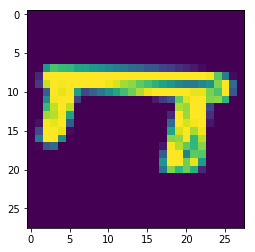

In [0]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

### Data preprocessing

In [0]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('x_train size: {}\nx_test size: {}\ny_train size: {}\ny_test size: {}'.format(
    len(x_train), len(x_test), len(y_train), len(y_test)))

x_train size: 400000
x_test size: 100000
y_train size: 400000
y_test size: 100000


# II. Program the Model

In [0]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                               padding='same',
                               input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(100, activation='softmax')) 

# Train model
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

print(model.summary())

W0718 01:59:08.045621 140389807081344 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

# III. Train the Model

In [0]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=15)

Train on 360000 samples, validate on 40000 samples
Epoch 1/15
360000/360000 - 13s - loss: 1.7903 - acc: 0.5610 - top_k_categorical_accuracy: 0.8040 - val_loss: 1.2985 - val_acc: 0.6733 - val_top_k_categorical_accuracy: 0.8863
Epoch 2/15
360000/360000 - 9s - loss: 1.1608 - acc: 0.7079 - top_k_categorical_accuracy: 0.9014 - val_loss: 1.1060 - val_acc: 0.7197 - val_top_k_categorical_accuracy: 0.9066
Epoch 3/15
360000/360000 - 9s - loss: 1.0212 - acc: 0.7407 - top_k_categorical_accuracy: 0.9166 - val_loss: 1.0093 - val_acc: 0.7425 - val_top_k_categorical_accuracy: 0.9173
Epoch 4/15
360000/360000 - 9s - loss: 0.9412 - acc: 0.7594 - top_k_categorical_accuracy: 0.9246 - val_loss: 0.9618 - val_acc: 0.7534 - val_top_k_categorical_accuracy: 0.9217
Epoch 5/15
360000/360000 - 9s - loss: 0.8896 - acc: 0.7721 - top_k_categorical_accuracy: 0.9301 - val_loss: 0.9219 - val_acc: 0.7638 - val_top_k_categorical_accuracy: 0.9251
Epoch 6/15
360000/360000 - 9s - loss: 0.8497 - acc: 0.7817 - top_k_categorical

# IV. Test the Model

### Evaluate overall accuracy

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: {:0.2f}%'.format(score[1] * 100))

Test accuracy: 79.28%


### Test on random dataset element

['pencil', 'baseball_bat', 'knife', 'paper_clip', 'sword']


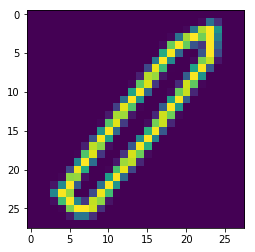

In [0]:
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# V. Deploy the Model

### Install TensorFlow.js

In [0]:
os.system("pip install tensorflowjs") 

0

### Save and convert model

In [0]:
model.save('keras.h5')
os.system("mkdir model")
os.system("tensorflowjs_converter --input_format keras keras.h5 model/")

0

### Zip and download model

In [0]:
os.system("cp sketchAI_classList.txt model/class_names.txt")

0

In [0]:
os.system("zip -r model.zip model")

0

In [0]:
from google.colab import files
files.download('model.zip')